# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

# %load_ext pycodestyle_magic

In [323]:
# %%pycodestyle

class MyKmeans:

    def __init__(self,
                 k=2,
                 metric='euclidean',
                 max_iter=1000,
                 random_state=None,
                 init='random',
                 eps=0.001):
        '''
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        '''

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.metric = metric
        self.labels = None
        self.centroids = None
        self.inertia_ = None
        self.eps = eps

    def fit(self, X, count_inertia=False):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        # Массив с метками кластеров для каждого объекта из X
        # Массив с центройдами кластеров
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))

        self._init_centroids(self.init, X)
        tmp_intervals = np.max(X, axis=0) - np.min(X, axis=0)

        for _ in range(self.max_iter):
            dist = metrics.pairwise_distances(X, self.centroids, metric=self.metric)
            self.labels = np.argmin(dist, axis=1)
            dif = np.empty(self.k)

            for i in range(self.k):
                tmp = np.mean(X[self.labels == i, :], axis=0)
                dif[i] = (np.abs(self.centroids[i] - tmp) /
                          tmp_intervals
                          ).sum()
                self.centroids[i] = tmp
            dif /= X.shape[1]
            if np.all(dif <= self.eps):
                break

        if count_inertia:
            self.inertia_ = 0
            for i in range(self.k):
                tmp = np.abs(X[self.labels == i] - self.centroids[i])
                self.inertia_ += (tmp * tmp).sum()

        return self

    def predict(self, X):
        '''
        Процедура предсказания кластера
        Возвращает метку ближайшего кластера для каждого объекта
        '''
        dist = metrics.pairwise_distances(X, self.centroids, metric=self.metric)
        return np.argmin(dist, axis=1)

    def _init_centroids(self, method, X):
        if method == 'random':
            centroids_indicies = np.random.choice(np.arange(X.shape[0]),
                                                  size=self.k,
                                                  replace=False
                                                  )
            self.centroids = X[centroids_indicies]

        elif method == 'k-means++':

            self.centroids[0, :] = X[np.random.randint(low=0, high=X.shape[0])]
            for i in range(1, self.k):
                dist = metrics.pairwise_distances(X, self.centroids, metric=self.metric)
                min_dist = np.min(dist[:, :i], axis=1)
                sum_ = min_dist.sum()
                centr_sum = np.random.uniform(0, sum_)
                sums = np.cumsum(min_dist)
                self.centroids[i, :] = X[sums > centr_sum][0]
        else:
            assert 'init not Implemented'


class MyMiniBatchKMeans(MyKmeans):
    def __init__(self,
                 k=2,
                 metric='euclidean',
                 max_iter=1000,
                 random_state=None,
                 init='random',
                 batch_size=0.4,
                 eps=1
                 ):
        super().__init__(k,
                         metric,
                         max_iter,
                         random_state,
                         init,
                         eps=eps
                         )
        self.batch_size = batch_size

    def fit(self, X, count_inertia=False):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        # Массив с центройдами кластеров
        self.labels = np.zeros(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))

        super()._init_centroids(self.init, X)

        batch_sz = int(X.shape[0] * self.batch_size)

        tmp_intervals = np.max(X, axis=0) - np.min(X, axis=0)
        tmp_counter = np.zeros(self.k)

        for j in range(self.max_iter):
            batch = np.random.randint(low=0, high=X.shape[0], size=batch_sz)
            dist = metrics.pairwise_distances(X[batch], self.centroids, metric=self.metric)

            tmp_labels = np.argmin(dist, axis=1)
            dif = np.zeros(self.k)

            for i in range(self.k):
                k_labels = (tmp_labels == i)
                if k_labels.sum() > 2:
                    tmp_counter[i] += 1
                    rate = 1 / tmp_counter[i]
                    tmp = (1 - rate) * self.centroids[i] + \
                          rate * np.mean(X[batch][k_labels], axis=0)
                    dif[i] = (np.abs(self.centroids[i] - tmp) / tmp_intervals).sum()
                    self.centroids[i] = tmp
            dif /= X.shape[1]
            if np.all(dif < self.eps):
                break

        dist = metrics.pairwise_distances(X, self.centroids, metric=self.metric)
        self.labels = np.argmin(dist, axis=1)

        if count_inertia:
            self.inertia_ = 0
            for i in range(self.k):
                tmp = np.abs(X[self.labels == i] - self.centroids[i])
                self.inertia_ += (tmp * tmp).sum()
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [265]:
from sklearn.datasets import make_blobs

In [266]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

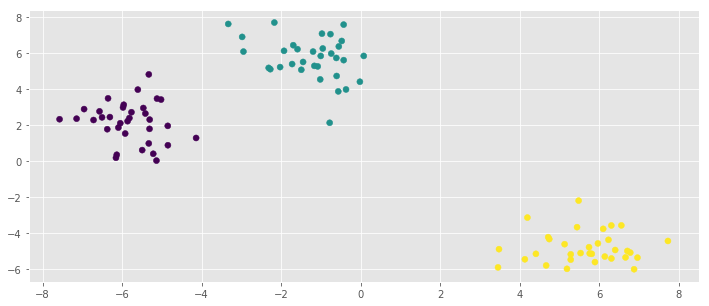

In [267]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

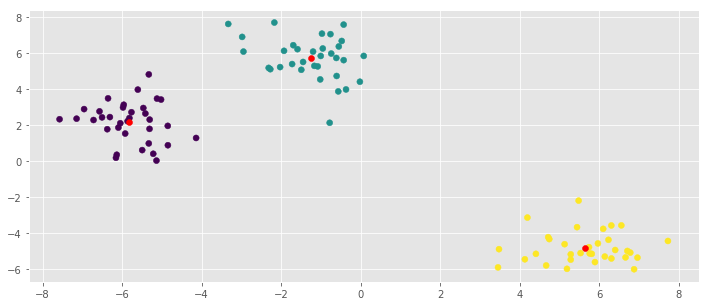

In [268]:
## Работоспособность MyKmeans
my_kmeans = MyKmeans(k=3)
my_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=y)
_ = plt.scatter(my_kmeans.centroids[:,0], my_kmeans.centroids[:, 1], c='red')

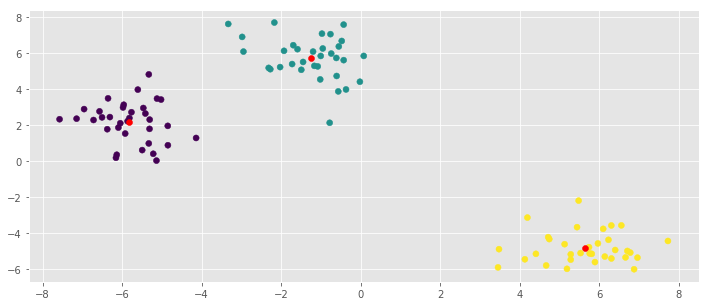

In [269]:
## Работоспособность MyKmeans++
my_kmeans = MyKmeans(k=3, init='k-means++')
my_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=y)
_ = plt.scatter(my_kmeans.centroids[:,0], my_kmeans.centroids[:, 1], c='red')

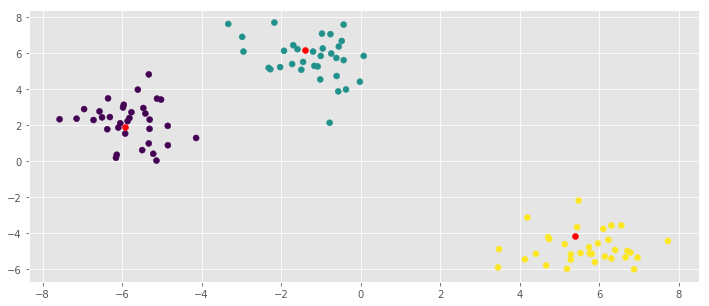

In [279]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
my_kmeans = MyMiniBatchKMeans(k=3)
my_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=y)
_ = plt.scatter(my_kmeans.centroids[:,0], my_kmeans.centroids[:, 1], c='red')

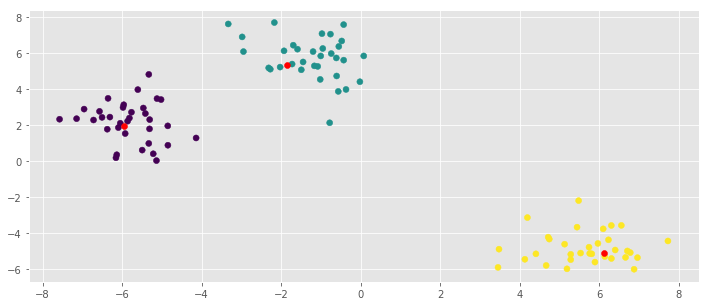

In [280]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
my_kmeans = MyMiniBatchKMeans(k=3, init='k-means++')
my_kmeans.fit(X)
plt.scatter(X[:,0], X[:, 1], c=y)
_ = plt.scatter(my_kmeans.centroids[:,0], my_kmeans.centroids[:, 1], c='red')

In [281]:
## Время выполнения алгоритма Kmeans из sklearn
kmeans = KMeans(n_clusters=3)
%time _ = kmeans.fit(X)

Wall time: 14.6 ms


In [282]:
## Время выполнения алгоритма MyKmeans
my_kmeans = MyKmeans(k=3)
%time _ = my_kmeans.fit(X)

Wall time: 1.57 ms


In [283]:
## Время выполнения алгоритма MyKmeans++
my_kmeans = MyKmeans(k=3, init='k-means++')
%time _ = my_kmeans.fit(X)

Wall time: 1.99 ms


In [284]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
my_kmeans = MyMiniBatchKMeans(k=3)
%time _ = my_kmeans.fit(X)

Wall time: 0 ns


In [285]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
my_kmeans = MyMiniBatchKMeans(k=3, init='k-means++')
%time _ = my_kmeans.fit(X)

Wall time: 2.98 ms


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [330]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

del df_sns['gradyear']
del df_sns['gender']
del df_sns['age']
del df_sns['friends']

display(df_sns.head())
df_std = df_sns.std()
df_mean = df_sns.mean()

df_sns = (df_sns - df_sns.mean()) / df_sns.std()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [349]:
## MyKMeans
my_kmeans = MyKmeans(k=9)
%time my_kmeans.fit(df_sns.values)
display(my_kmeans.centroids * df_std.values + df_mean.values)
display(np.bincount(my_kmeans.labels))

Wall time: 245 ms


array([[0.13, 0.10, 0.12, 0.08, 0.07, 0.00, 0.05, 0.03, 0.02, 0.08, 0.17,
        0.09, -0.00, 0.06, 0.03, 0.22, 0.13, 0.01, 0.49, 0.14, 0.26,
        0.09, 0.05, 0.00, 0.18, 0.04, 0.04, 0.12, 0.16, 0.06, 0.03, 0.02,
        0.12, 0.07, 0.05, 0.02],
       [0.37, 0.37, 0.22, 0.21, 0.22, 0.15, 0.15, 0.08, 0.09, 0.11, 0.75,
        0.23, 0.14, 0.18, 0.17, 0.95, 0.48, 0.04, 0.88, 0.30, 0.53, 0.45,
        0.11, 0.02, 0.90, 2.60, 0.12, 0.55, 0.83, 0.30, 0.10, 0.08, 0.21,
        0.13, 0.09, 0.05],
       [0.23, 0.22, 0.17, 0.14, 0.14, 0.06, 0.29, 0.06, 0.05, 0.10, 0.68,
        0.16, 0.06, 0.29, 0.07, 1.08, 0.98, 0.21, 1.30, 0.39, 1.22, 0.84,
        0.40, 0.11, 0.54, 0.11, 0.10, 0.63, 0.90, 0.33, 0.15, 0.11, 0.24,
        0.20, 0.07, 0.04],
       [0.21, 0.20, 0.23, 0.16, 0.19, 1.44, 0.10, 0.06, 0.06, 0.11, 0.32,
        0.13, 0.06, 0.14, 0.07, 0.36, 0.22, 0.02, 0.81, 0.23, 0.41, 0.21,
        0.08, 0.01, 0.38, 0.06, 0.09, 0.26, 0.59, 0.15, 0.08, 0.06, 0.15,
        0.11, 0.07, 0.03],
   

array([17211,   552,  4157,  2060,  2163,  1951,  1190,    14,   702],
      dtype=int64)

In [332]:
## MyKMeans++
my_kmeans = MyKmeans(k=9, init='k-means++')
%time my_kmeans.fit(df_sns.values)
display(np.bincount(my_kmeans.labels))

Wall time: 655 ms


array([19991,   848,   832,  1017,   529,  3552,   747,  1353,  1131],
      dtype=int64)

In [333]:
## MyKMeans с MiniBatchMyKMeans
my_kmeans = MyMiniBatchKMeans(k=9)
%time my_kmeans.fit(df_sns.values)
np.bincount(my_kmeans.labels)

Wall time: 87.2 ms


array([  806,    38, 17646,  5991,   316,  1675,  2857,   187,   484],
      dtype=int64)

In [334]:
## MyKMeans++ с MiniBatchMyKMeans
my_kmeans = MyMiniBatchKMeans(k=9, init='k-means++')
%time my_kmeans.fit(df_sns.values)
np.bincount(my_kmeans.labels)

Wall time: 547 ms


array([18364,   542,  1033,  1467,  2756,   437,  2411,  2989,     1],
      dtype=int64)

In [338]:
kmeans = KMeans(n_clusters=9)
%time kmeans.fit(X=df_sns.values)
display(kmeans.cluster_centers_ * df_std.values + df_mean.values)
np.bincount(kmeans.labels_)

Wall time: 6.81 s


array([[0.11, 0.10, 0.10, 0.06, 0.07, 0.08, 0.05, 0.03, 0.06, 0.06, 0.15,
        0.10, 0.08, 0.05, 0.03, 0.22, 0.16, 0.01, 0.55, 0.15, 0.31, 0.14,
        0.07, 0.00, 0.19, 0.04, 0.04, 0.12, 0.17, 0.05, 0.01, 0.01, 0.12,
        0.08, 0.05, 0.02],
       [0.38, 0.40, 0.30, 0.15, 0.27, 0.26, 0.32, 0.11, 0.15, 0.19, 0.63,
        0.24, 0.20, 0.32, 0.13, 0.69, 0.19, 0.01, 0.92, 0.29, 0.47, 0.23,
        0.10, 0.01, 0.91, 0.18, 0.22, 0.67, 0.93, 0.42, 1.51, 1.17, 0.22,
        0.15, 0.11, 0.07],
       [0.26, 0.25, 0.17, 0.10, 0.14, 0.29, 0.30, 0.06, 0.10, 0.10, 0.99,
        0.23, 0.35, 0.40, 0.09, 1.22, 0.26, 0.01, 1.09, 0.36, 0.58, 0.47,
        0.11, 0.00, 0.80, 0.40, 0.14, 0.75, 1.03, 0.42, 0.06, 0.03, 0.22,
        0.17, 0.11, 0.04],
       [0.00, 2.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 1.00,
        22.00, 1.00, 0.00, 0.00, 1.00, 1.00, 0.00, 0.00, 1.00, 10.00,
        0.00, 1.00, 0.00, 12.00, 2.00, 327.00, 0.00, 0.00, 1.00, 0.00,
        0.00, 6.00, 6.00, 6.00, 0.00],

array([19714,   853,  4370,     1,   486,   501,  2564,   933,   578],
      dtype=int64)

In [102]:
## Вывод
"""
Сложно по столь крупным векторам сложно сказать по каким признакам распределились наши классы.
Но судя по скорости работы выигрывают MiniBatch алгоритмы, как и ожидалось, но свое предпочтение я отдаю MiniBatch kmeans++
Так как хоть по скорости он уступает обычной версии MiniBatch, но по стабильности kmeans++ лучше.
"""